In [50]:
import os
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")
sns.set_palette("Paired")

In [51]:
# Calcultation based on CCI1 in 2021 paper by Li et al.: How well do commonly used co-contraction 
# indices approximate lower limb joint stiffness trends durig gait for idividuals post-stroke?

def calculate_cocontraction(proc_1, proc_2):
    inputlow = np.minimum(np.abs(proc_1), np.abs(proc_2))
    inputhigh = np.maximum(np.abs(proc_1), np.abs(proc_2))
    cocontraction = np.zeros_like(proc_1)
    non_zero = inputhigh != 0 
    cocontraction[non_zero] = (inputlow[non_zero] / inputhigh[non_zero]) * (inputhigh[non_zero] + inputlow[non_zero])
    return cocontraction

In [90]:
# Read in training data
current_directory = os.getcwd()

# data = []
data = np.empty((0,12))

# participants
participants = ('SN001', 'SN002', 'SN003', 'SN004', 'SN005', 'SN006', 'SN007', 'SN008', 'SN009', 'SN010', 'SN012', 'SN013', 'SN014', 'SN015', 'SN016', 'SN017', 'SN018', 'SN019', 'SN020', 'SN021')

SN=0
for p in participants:
    SN = SN+1
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    BN = 0
    for b in control_folders:
        BN += 1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            trials = pd.read_csv(os.path.join(b, 'trials.csv'))

            if trials["emg"][0] == 1: 
                if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
                    data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'))
                if os.path.isfile(os.path.join(b, 'noise.hdf5')):
                    noise = h5py.File(os.path.join(b, 'noise.hdf5'))
                
                n_total_trials = trials.shape[0]
                    
                # proc_1 = np.array(data_proc['1'][:][0])
                # proc_2 = np.array(data_proc['1'][:][1])
                
                # li at al. paper CCI 1 (numpy min max calc)
                # cocontract v noise
                # cocontract block 2 v 4 1 v 3
                # li et al paper contraction over time
                # one big df all trials all timepoints with each calculated cocontract
                    
                for i in range(n_total_trials):
                    data_trial = data_proc.get(str(i))[()].T
                    noise_signal = noise.get(str(i))[()].flatten()
                    noise_signal = noise_signal.reshape(-1,1)
                    SN_array = np.ones((data_trial.shape[0],1))*SN
                    BN_array = np.ones((data_trial.shape[0],1))*BN
                    time_points = np.arange(0., 16., .05)
                    time_points = np.reshape(time_points, (-1,1))
                    trial_no = np.ones((data_trial.shape[0],1))*trials["trial"][i]
                    noise_array = np.ones((data_trial.shape[0],1))*trials["noise"][i]
                    score = np.ones((data_trial.shape[0],1))*trials["score"][i]
                    soa = np.ones((data_trial.shape[0],1))*trials["soa"][i]
                    gender = np.ones((data_trial.shape[0],1))*trials["gender"][i]
                        
                    proc_1 = data_trial[:, 0]
                    proc_2 = data_trial[:, 1]
                    cocontraction = calculate_cocontraction(proc_1, proc_2).reshape(-1, 1)
                    # cocontraction = calculate_cocontraction(data_trial[:,0], data_trial[:,1])
                    # cocontraction = np.reshape(cocontraction, (-1,1))
                
                    total_array = np.concatenate((SN_array, BN_array, trial_no, noise_array, score, soa, gender, 
                                                  time_points, data_trial, cocontraction, noise_signal), axis=1,)
                        
                    data = np.append(data, total_array, axis=0)
            
results = pd.DataFrame(data, columns=['Participant', 'Block', 'Trial', 'Noise', 'Score', 'SoA', 'Gender', 'Time', 'MAV1', 'MAV2', 'Cocontraction', 'Noise Signal'])

# results[['Participant', 'Block', 'Trial', 'SoA', 'Gender']] = results[['Participant', 'Block', 'Trial', 'SoA', 'Gender']].astype(int)

results

Participant  Block  Trial  Noise     Score  SoA  Gender   Time  \
0               1.0    1.0    0.0    0.1  0.609251  4.0     0.0   0.00   
1               1.0    1.0    0.0    0.1  0.609251  4.0     0.0   0.05   
2               1.0    1.0    0.0    0.1  0.609251  4.0     0.0   0.10   
3               1.0    1.0    0.0    0.1  0.609251  4.0     0.0   0.15   
4               1.0    1.0    0.0    0.1  0.609251  4.0     0.0   0.20   
...             ...    ...    ...    ...       ...  ...     ...    ...   
255995         20.0    3.0   19.0    0.1  0.702621  4.0     1.0  15.75   
255996         20.0    3.0   19.0    0.1  0.702621  4.0     1.0  15.80   
255997         20.0    3.0   19.0    0.1  0.702621  4.0     1.0  15.85   
255998         20.0    3.0   19.0    0.1  0.702621  4.0     1.0  15.90   
255999         20.0    3.0   19.0    0.1  0.702621  4.0     1.0  15.95   

            MAV1      MAV2  Cocontraction  Noise Signal  
0       0.000000  0.390181            0.0           0.0  
1       0.000000  0.892691            0.0           0.0  
2       0.000000  1.277282            0.0           0.0  
3       0.000000  1.372502            0.0           0.0  
4       0.000000  1.615958            0.0           0.0  
...          ...       ...            ...           ...  
255995  0.162281  0.000000            0.0           0.0  
255996  0.148400  0.000000            0.0           0.0  
255997  0.142450  0.000000            0.0           0.0  
255998  0.141563  0.000000            0.0           0.0  
255999  0.150315  0.000000            0.0           0.0  

[256000 rows x 12 columns]

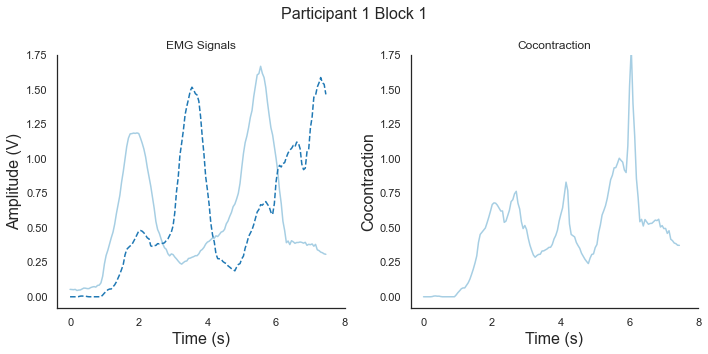

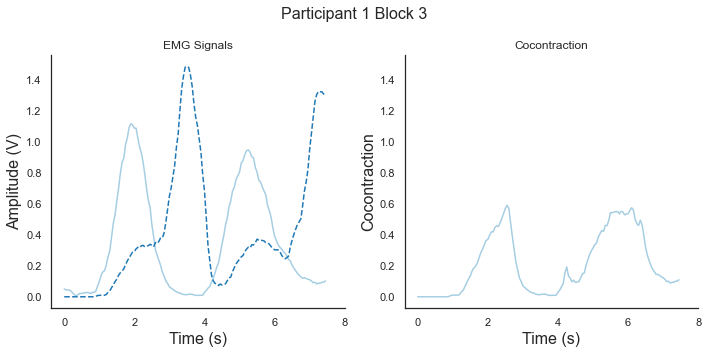

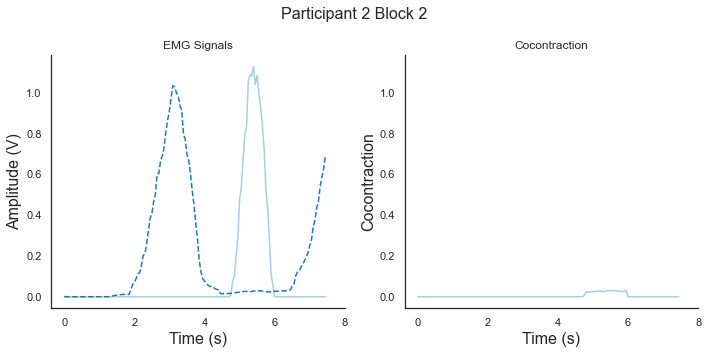

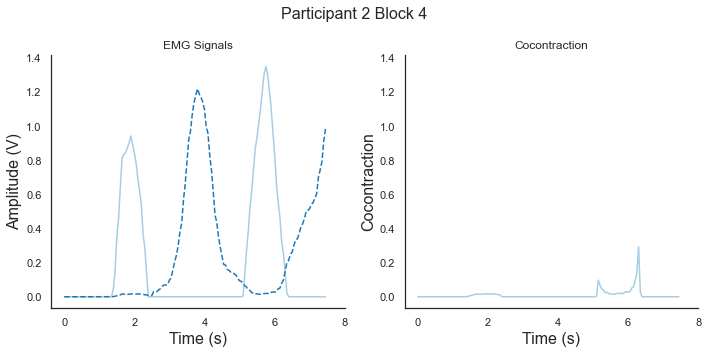

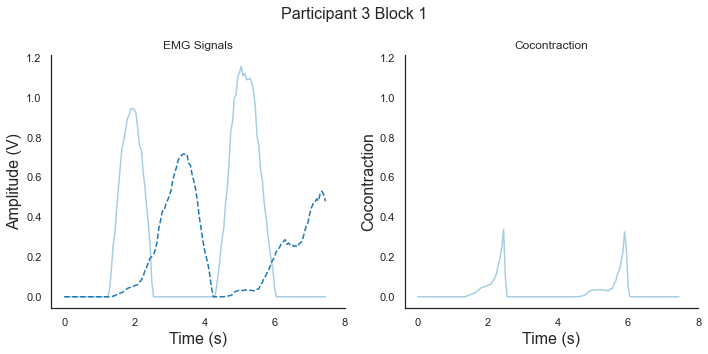

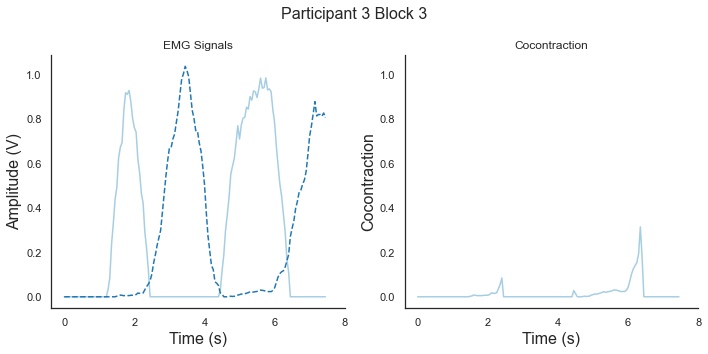

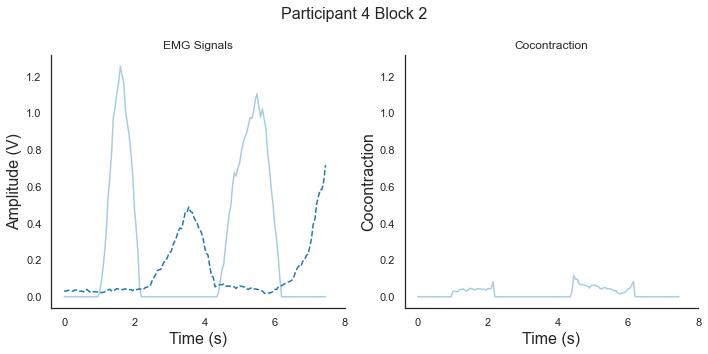

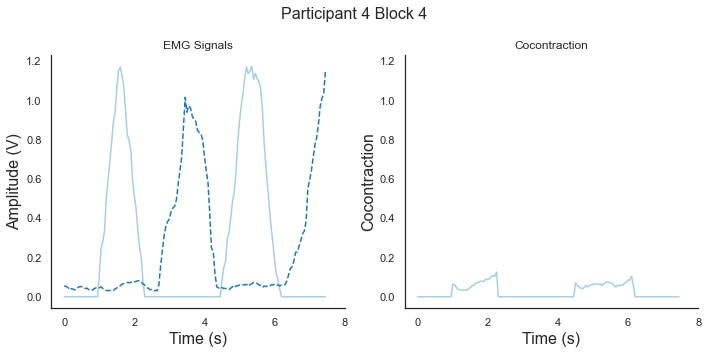

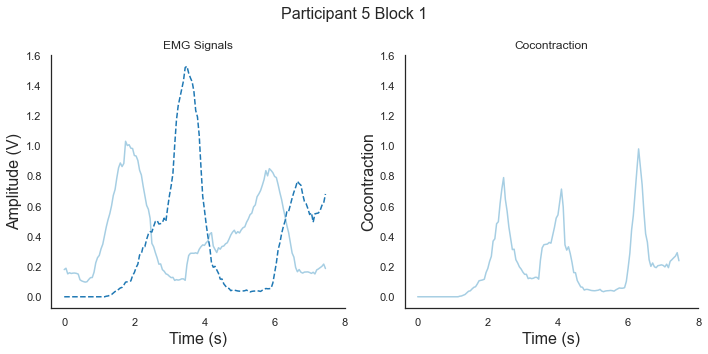

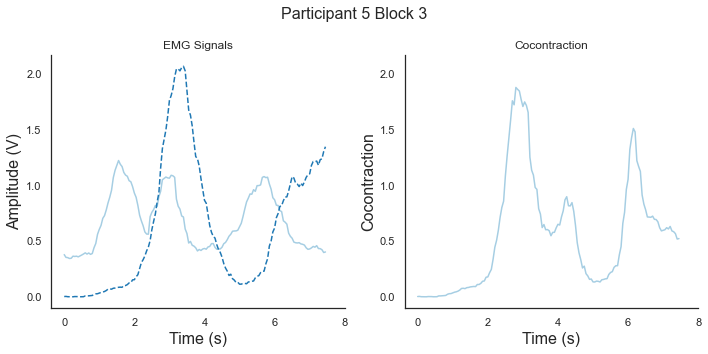

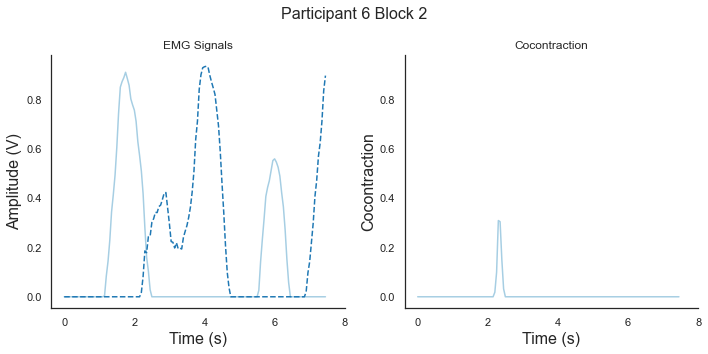

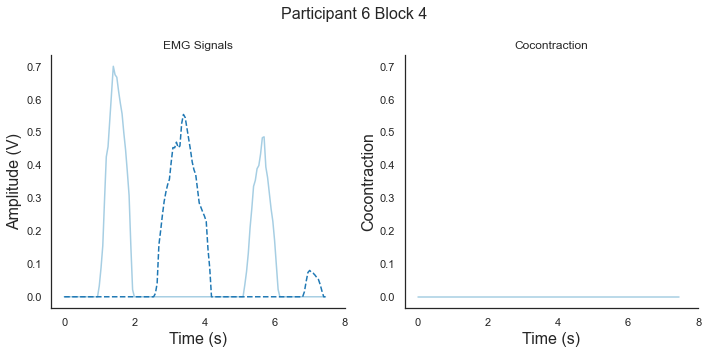

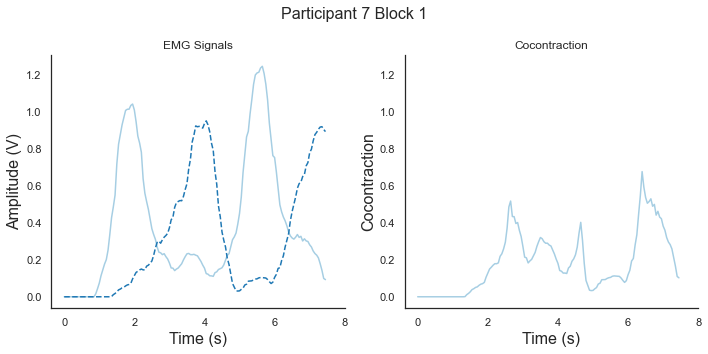

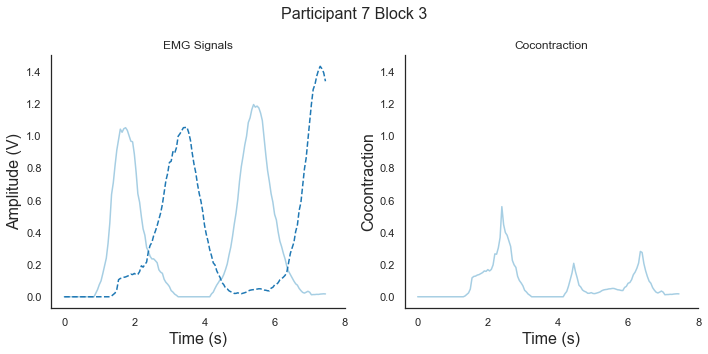

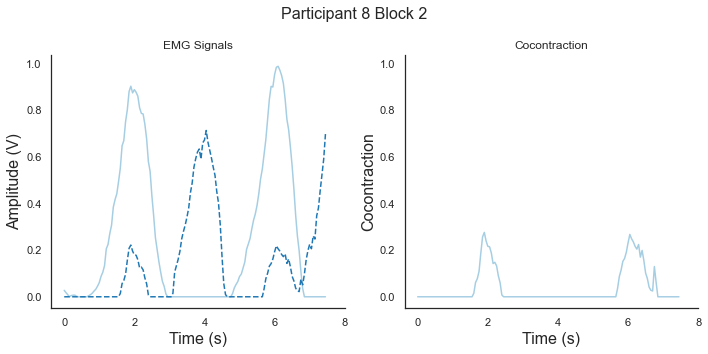

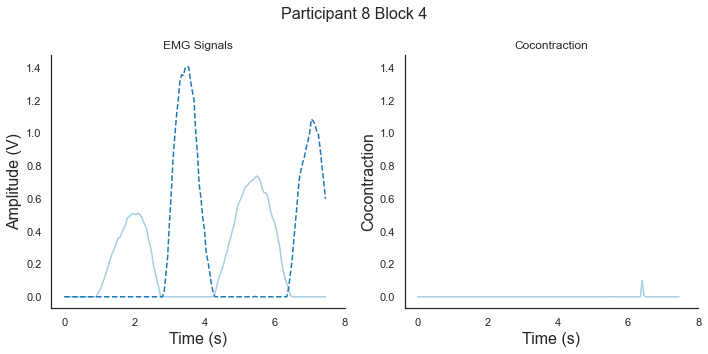

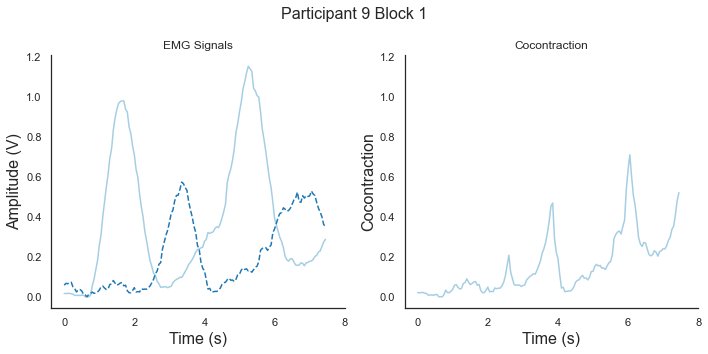

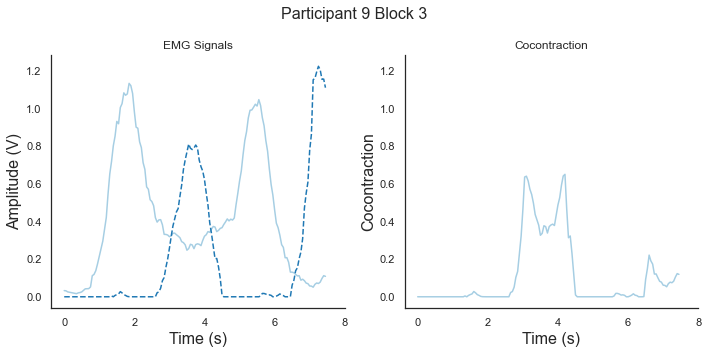

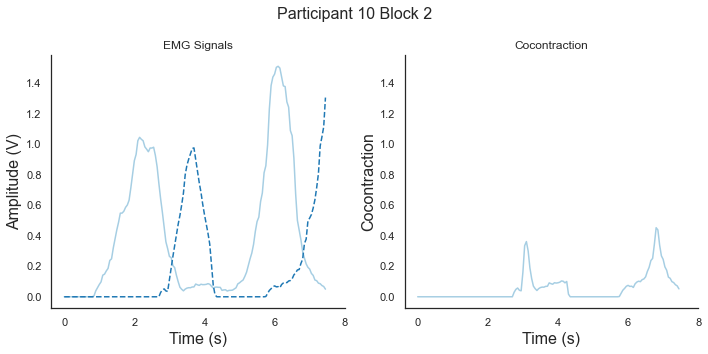

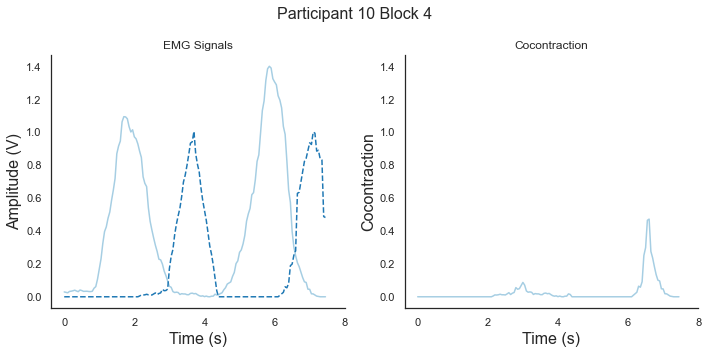

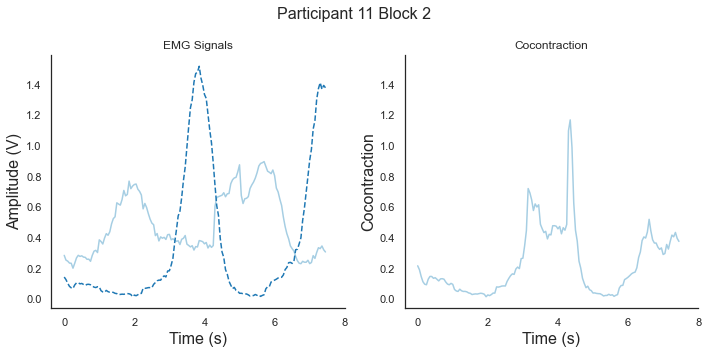

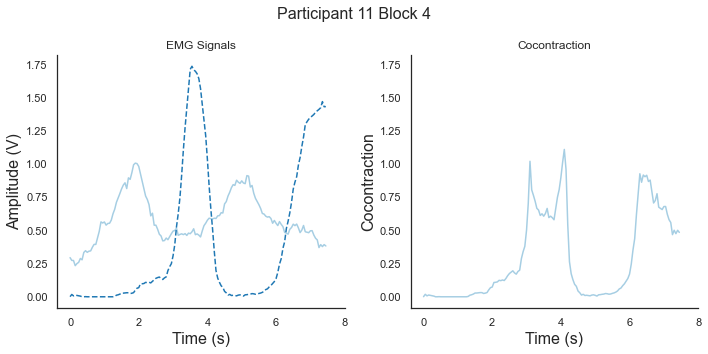

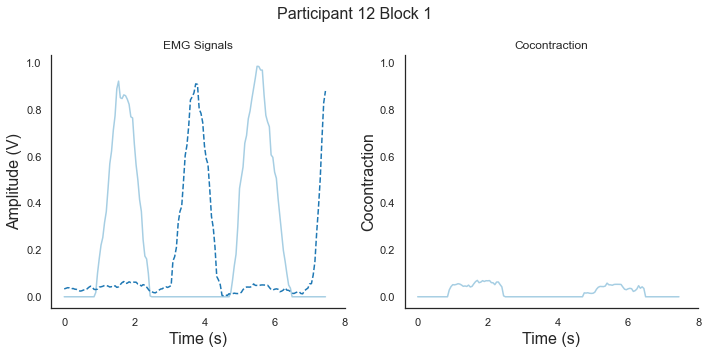

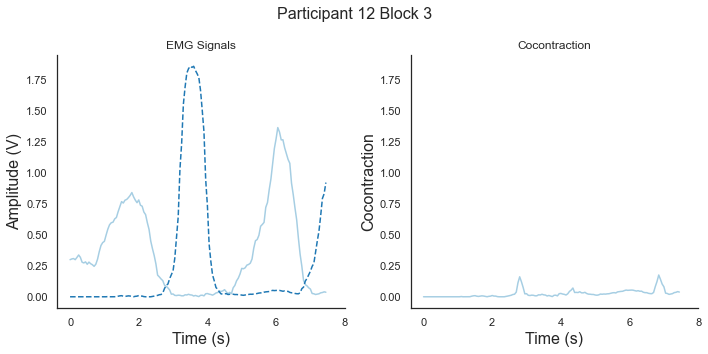

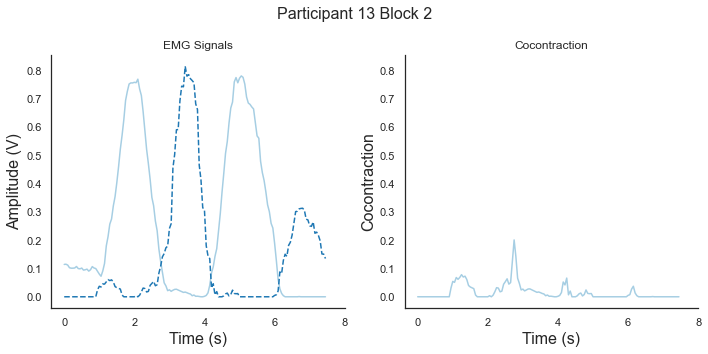

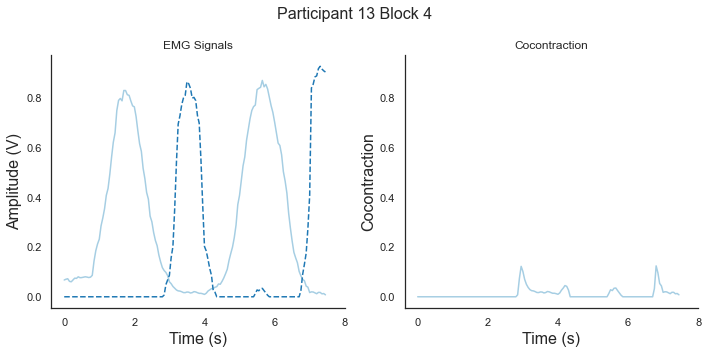

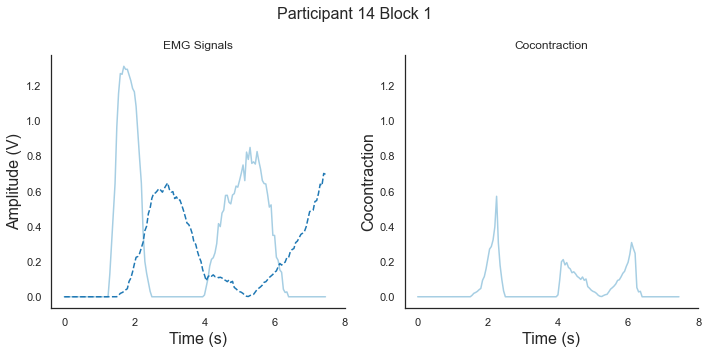

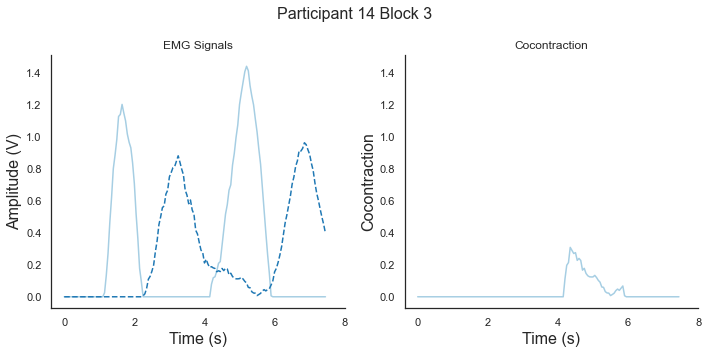

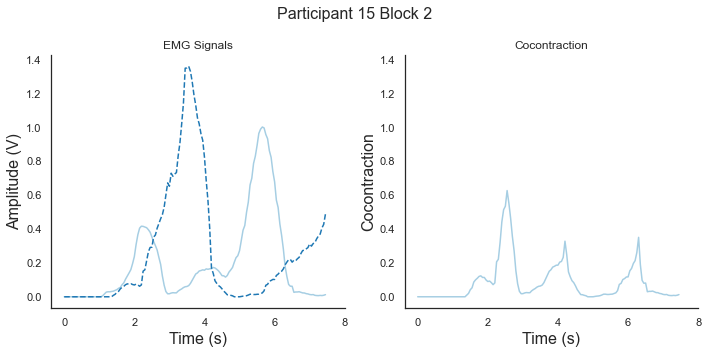

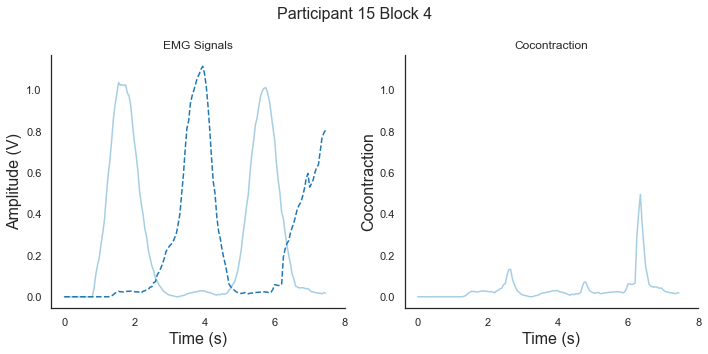

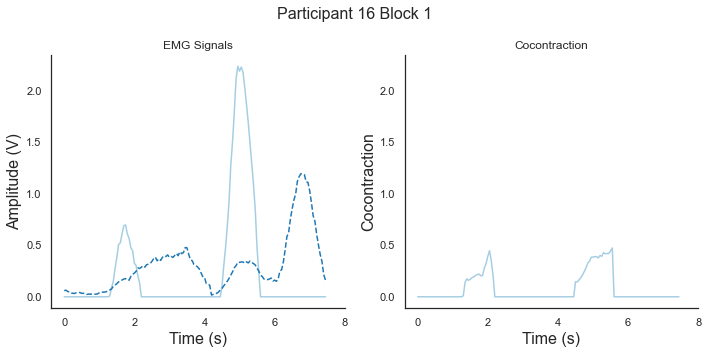

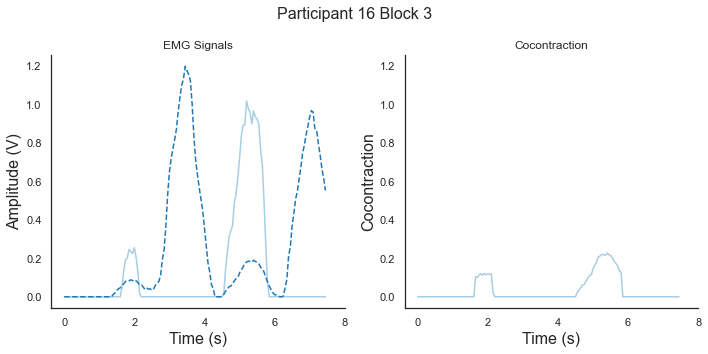

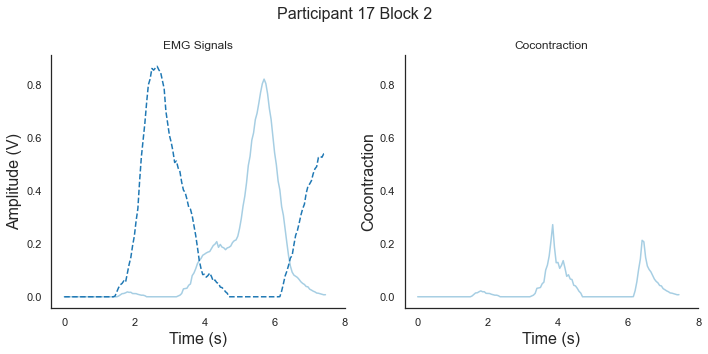

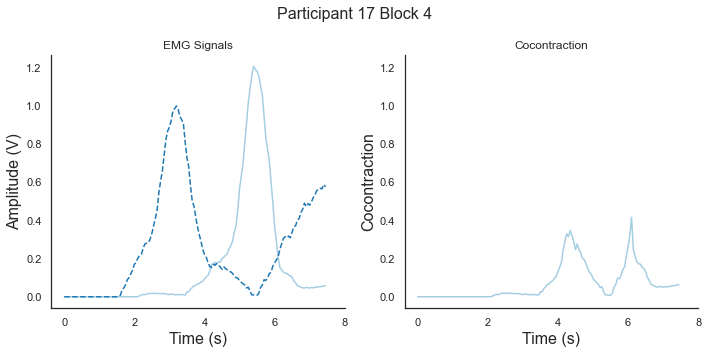

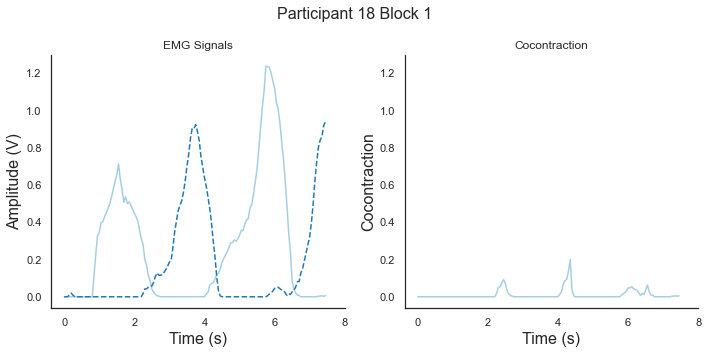

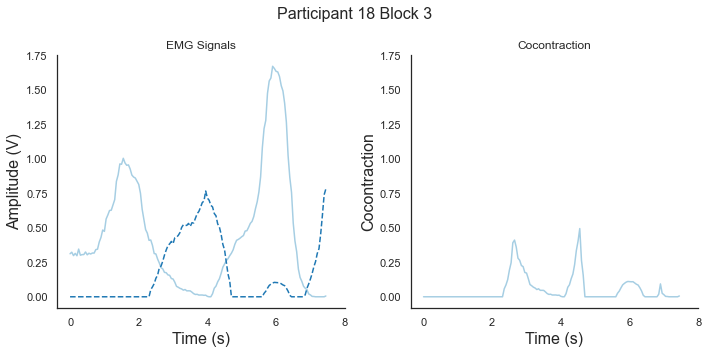

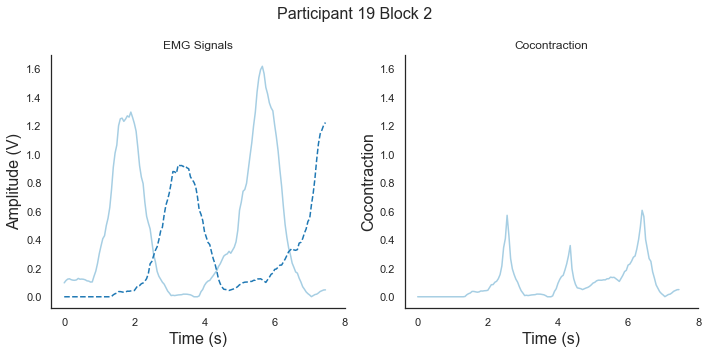

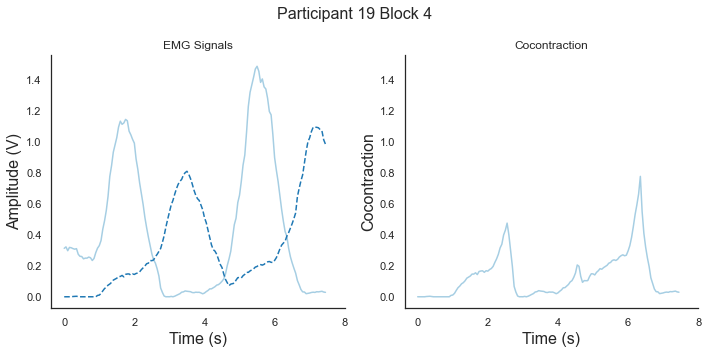

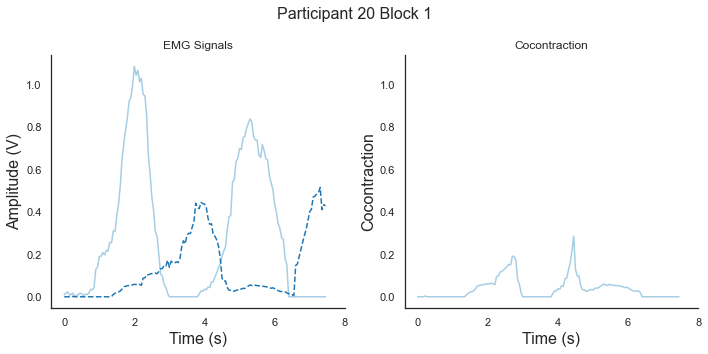

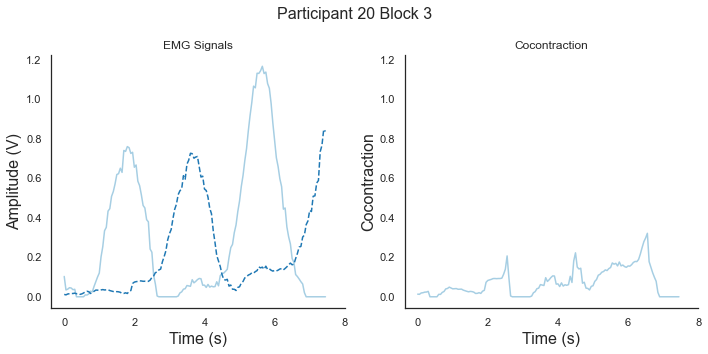

In [53]:
participants = ('SN001', 'SN002', 'SN003', 'SN004', 'SN005', 'SN006', 'SN007', 'SN008', 'SN009', 'SN010', 'SN012', 'SN013', 'SN014', 'SN015', 'SN016', 'SN017', 'SN018', 'SN019', 'SN020', 'SN021')

SN = 0
for p in participants:
    SN = SN + 1
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    BN = 0
    for b in control_folders:
        BN = BN + 1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            trials = pd.read_csv(os.path.join(b, 'trials.csv'))
            
            if trials["emg"][0] == 1:
                if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
                    data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'), 'r')
                    proc_1 = data_proc['1'][0:][0]
                    proc_2 = data_proc['1'][0:][1]
     
                    cocontraction = calculate_cocontraction(proc_1[50:200], proc_2[50:200])
                    
                    plt.figure(figsize=(10, 5))
                    
                    plt.subplot(1, 2, 1)
                    sns.lineplot(data=proc_1[50:200])
                    sns.lineplot(data=proc_2[50:200], linestyle='dashed')
                    plt.xlabel('Time (s)', fontsize=16)
                    plt.ylabel('Amplitude (V)', fontsize=16)
                    plt.xticks(ticks=[0, 40, 80, 120, 160], labels=[0, 2, 4, 6, 8])
                    plt.title('EMG Signals')
                    sns.despine()
                    
                    # make y limits of 2nd sublot equal to 1st subplot
                    y_limits = plt.gca().get_ylim()
                    
                    plt.subplot(1, 2, 2)
                    plt.plot(cocontraction, label='Cocontraction')
                    # plt.fill_between(range(0, 160), cocontraction[0:160] - std_cocontraction, cocontraction[0:160] + std_cocontraction, color='blue', alpha=0.08)
                    plt.xlabel('Time (s)', fontsize=16)
                    plt.ylabel('Cocontraction', fontsize=16)
                    plt.xticks(ticks=[0, 40, 80, 120, 160], labels=[0, 2, 4, 6, 8])
                    plt.ylim(y_limits)
                    plt.title('Cocontraction')
                    sns.despine()
                    
                    plt.suptitle(f'Participant {SN} Block {BN}', fontsize=16)
                    
                    plt.tight_layout()
                    plt.show()


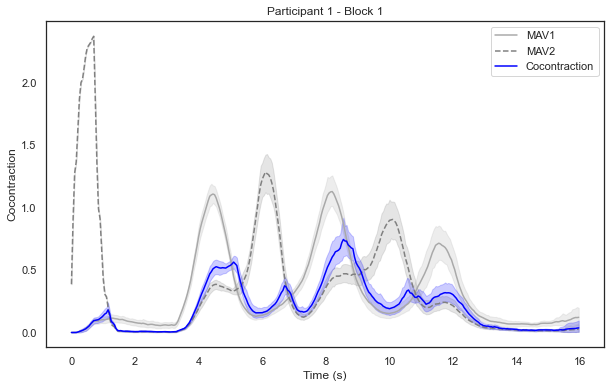

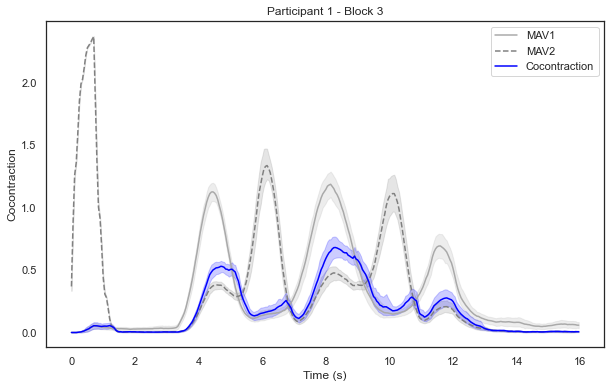

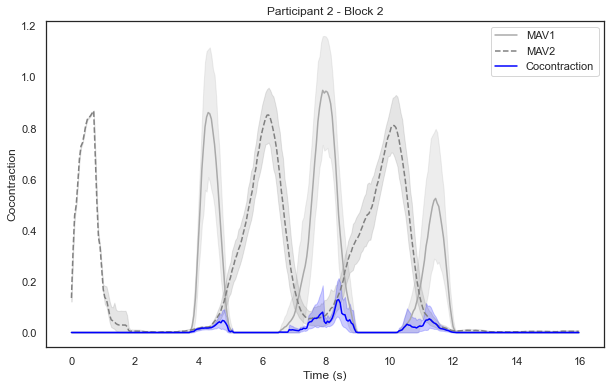

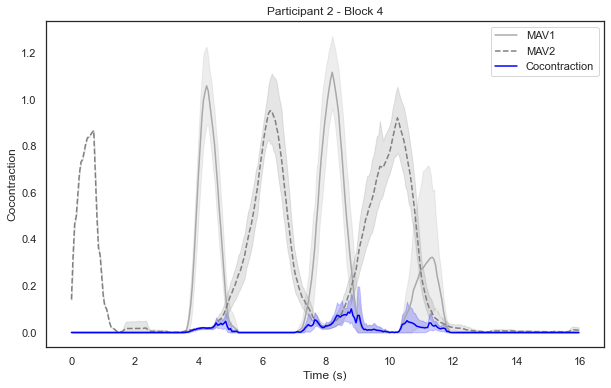

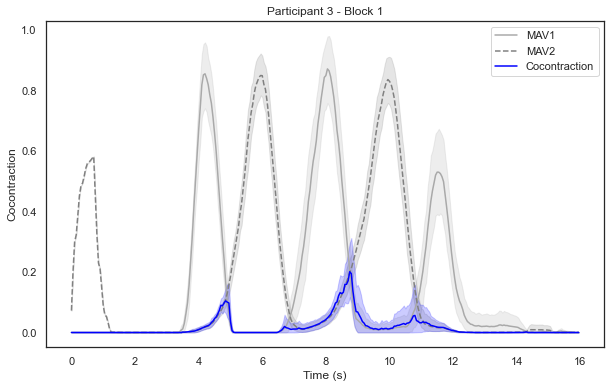

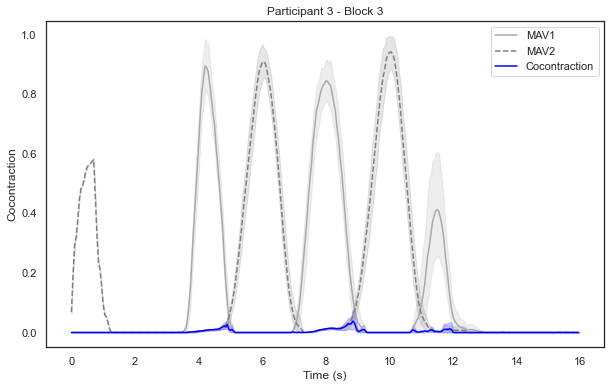

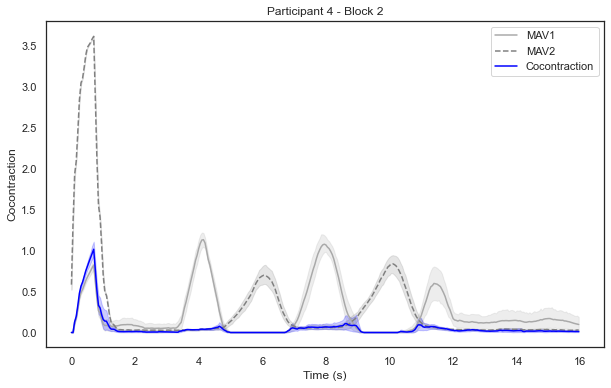

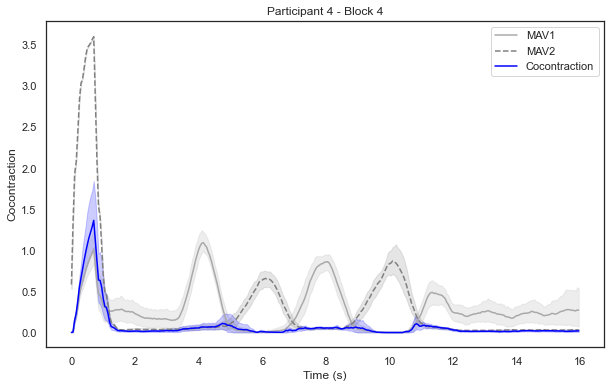

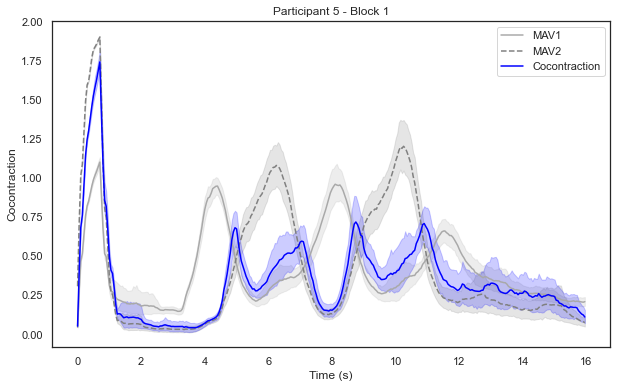

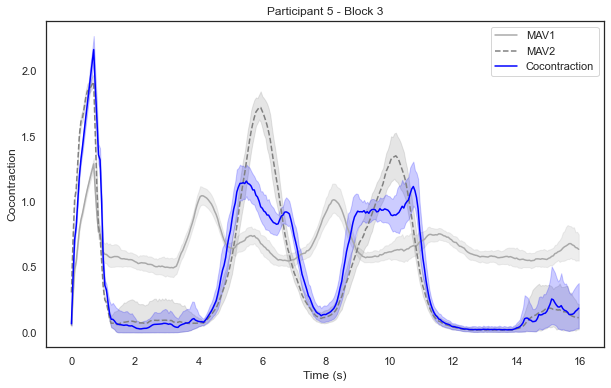

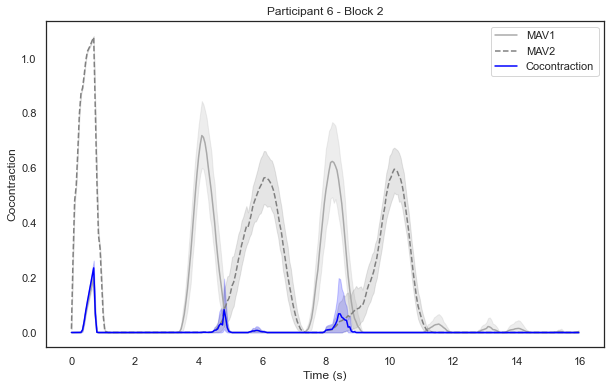

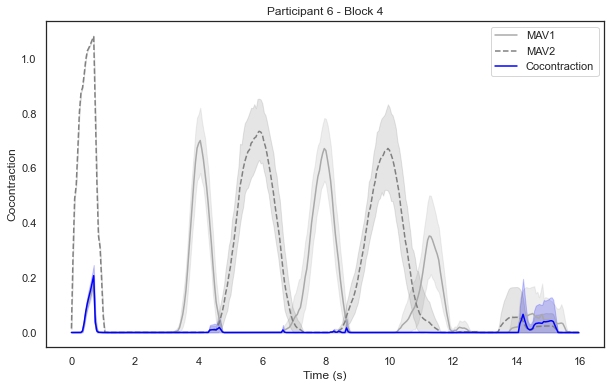

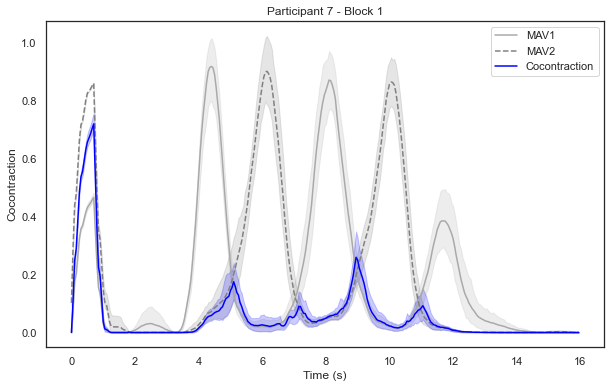

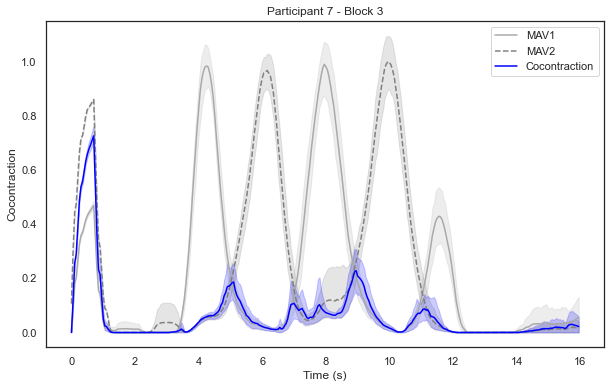

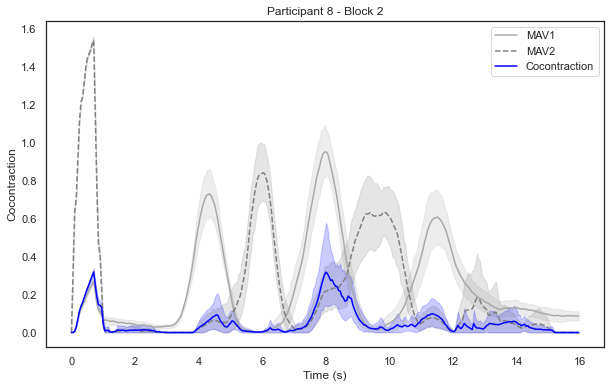

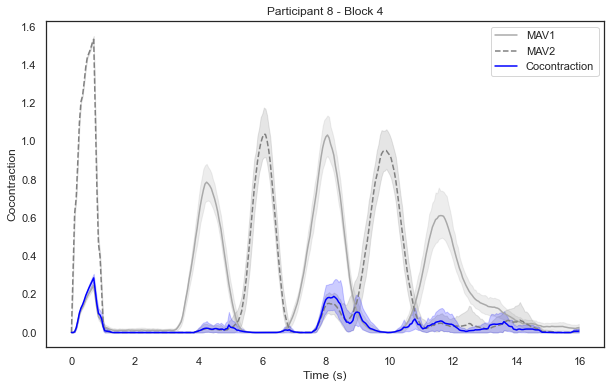

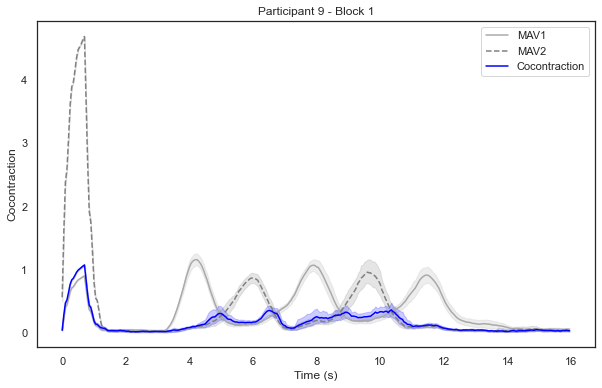

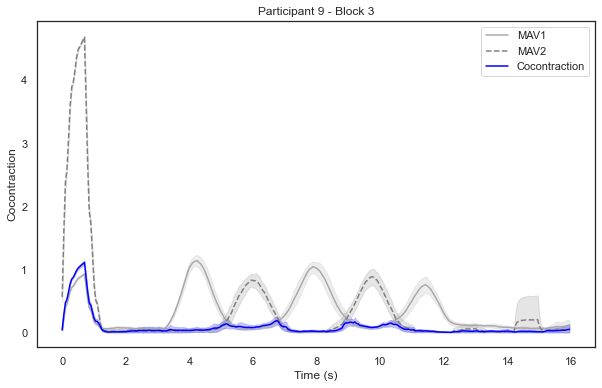

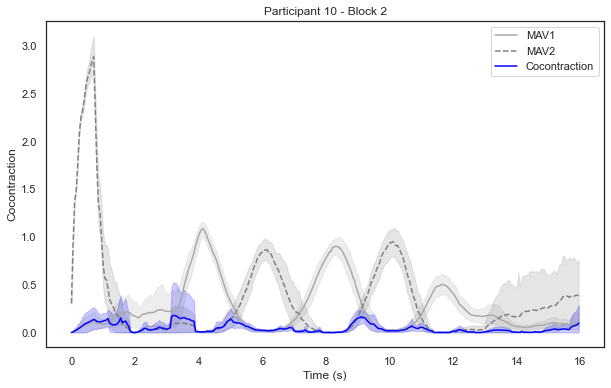

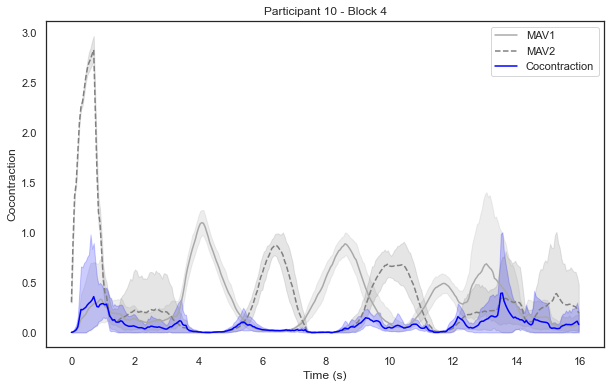

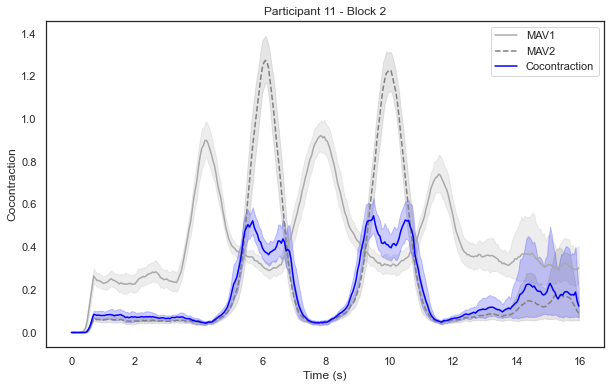

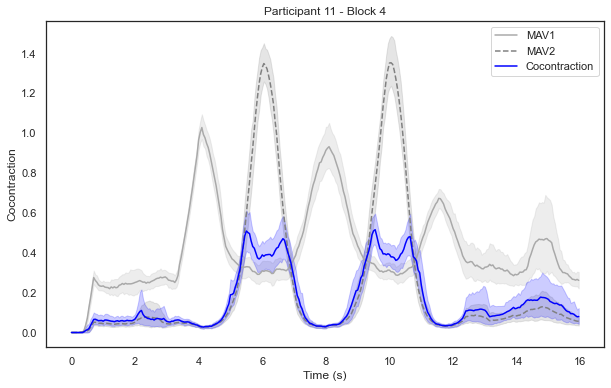

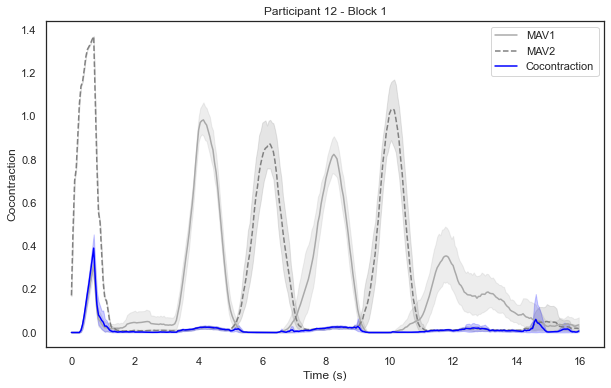

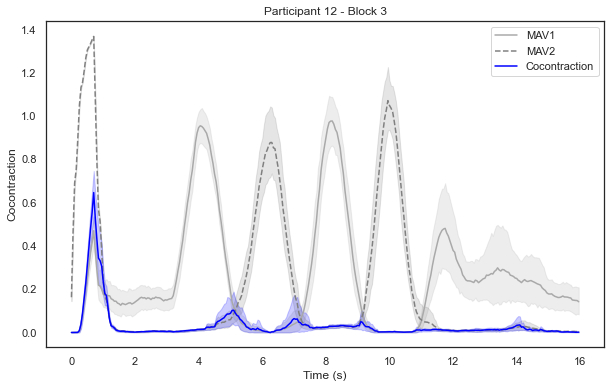

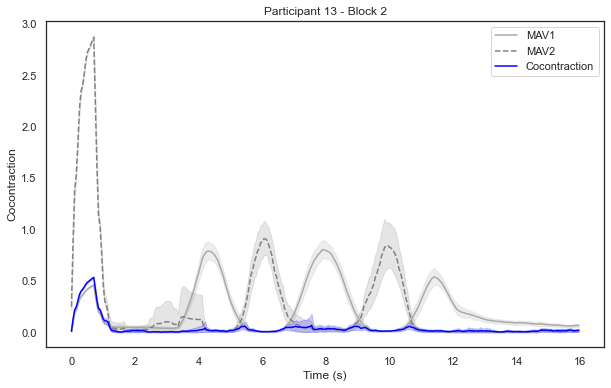

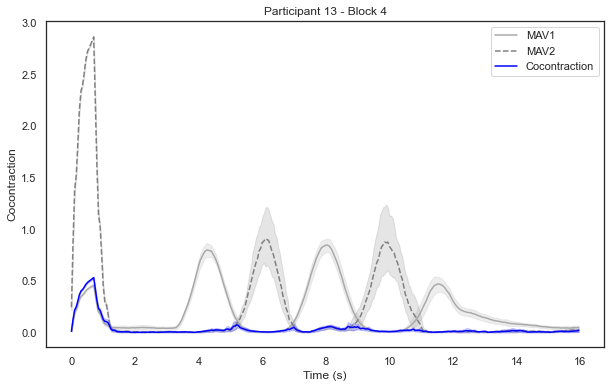

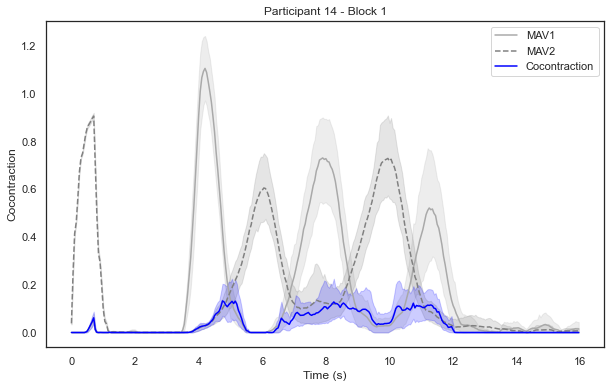

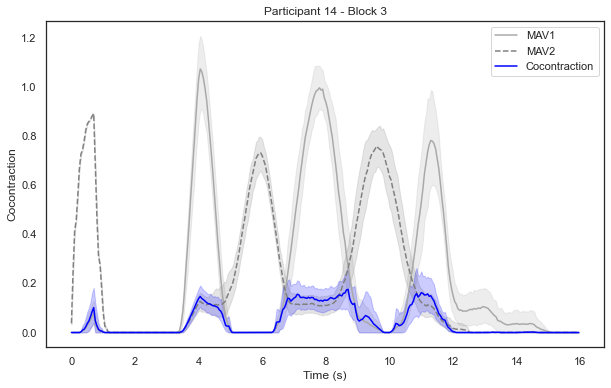

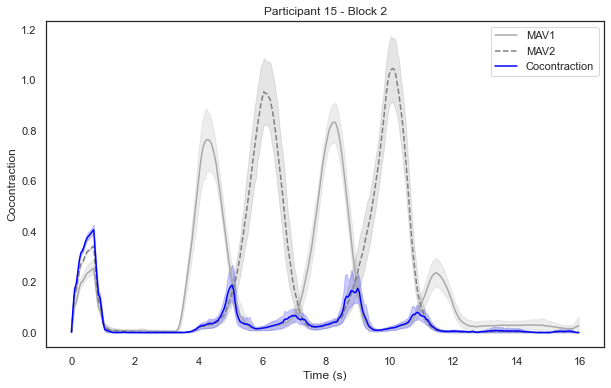

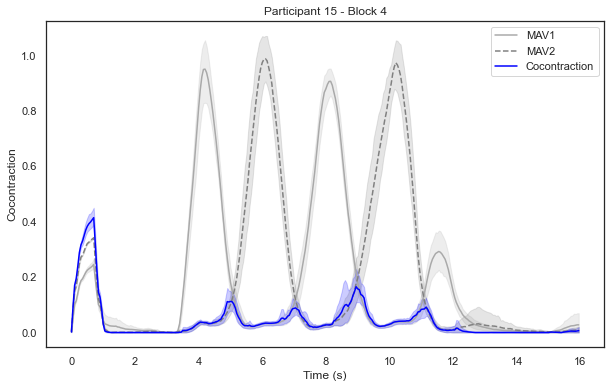

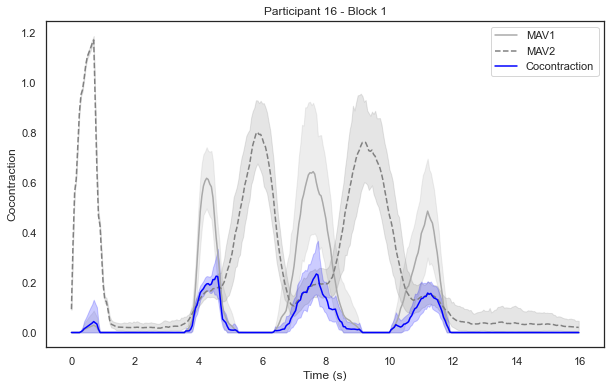

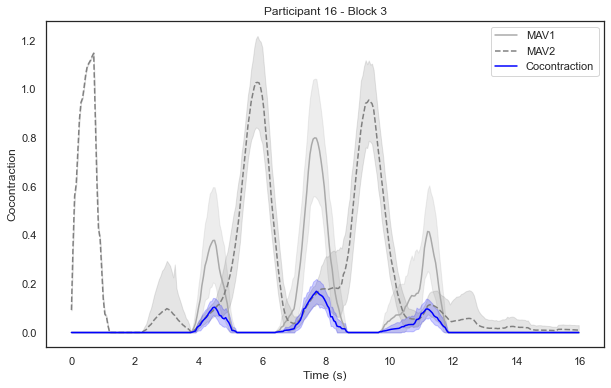

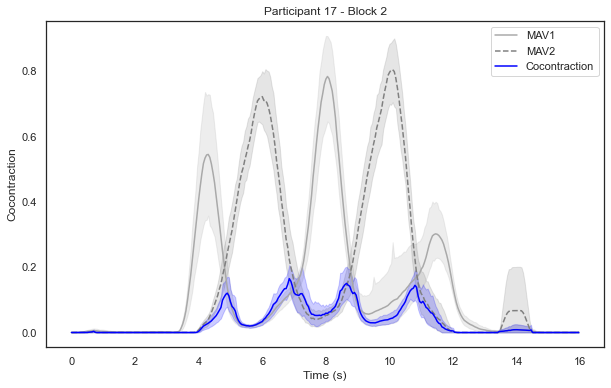

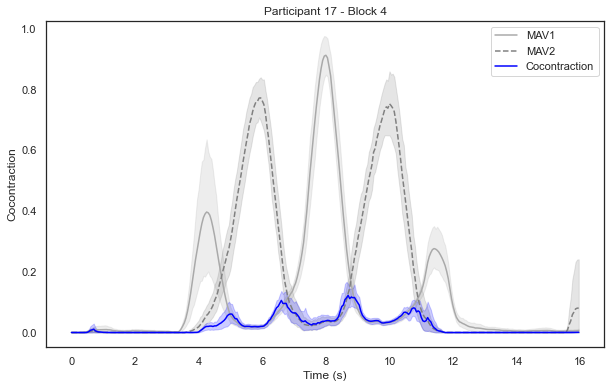

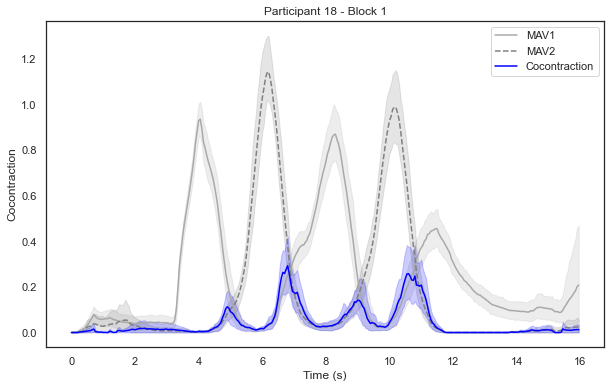

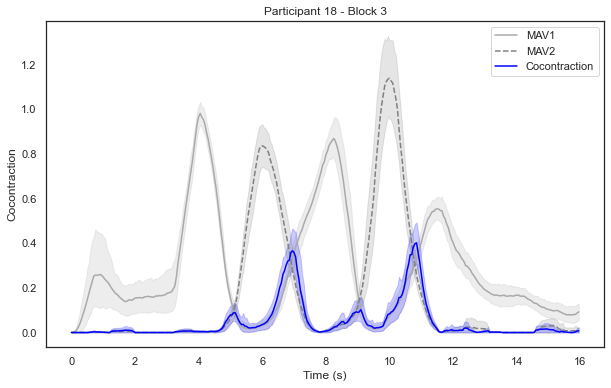

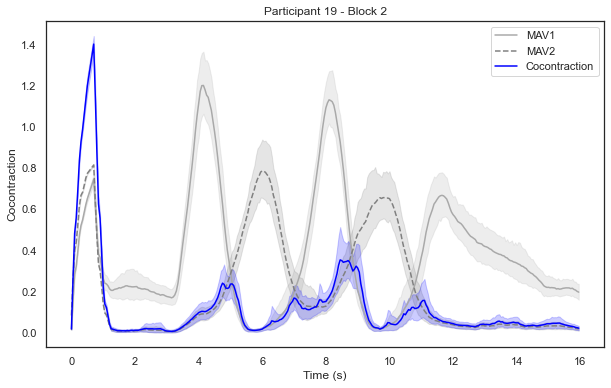

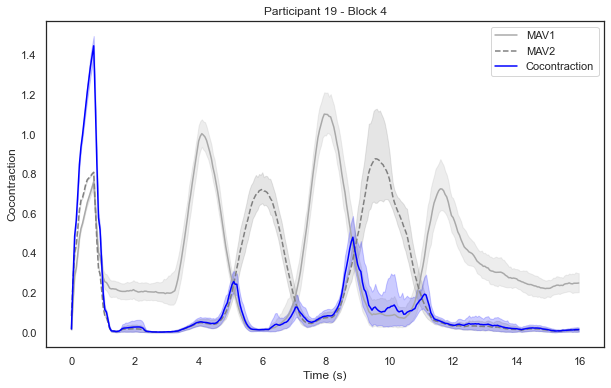

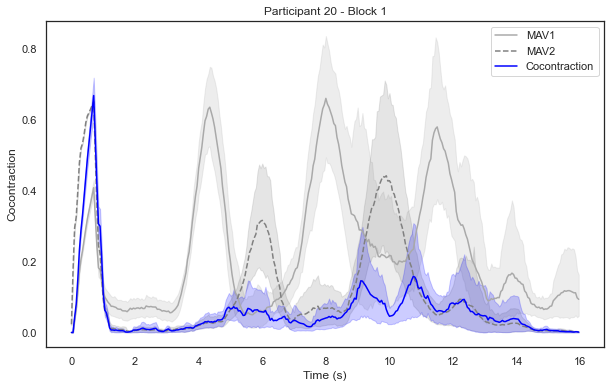

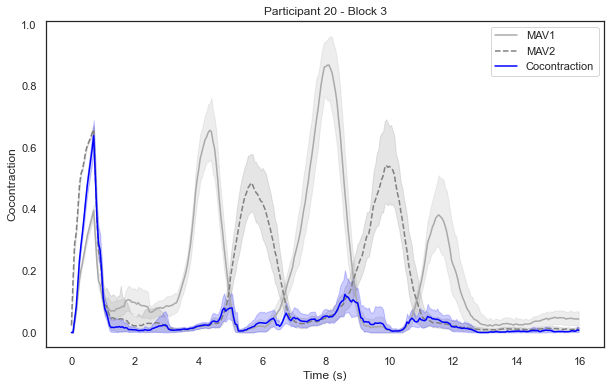

In [54]:
participants = results['Participant'].unique()
    
for p in participants:
    df_SN = results[results["Participant"] == p]
    # participant_data = results[results['Participant'] == participant]
    block = df_SN['Block'].unique()
        
    for b in block:
        df_SN_BN = df_SN[df_SN["Block"] == b] 
        # trial_data = participant_data[participant_data['Trial'] == trial]
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_SN_BN, x="Time", y="MAV1", color='darkgrey', label='MAV1')
        sns.lineplot(data=df_SN_BN, x="Time", y="MAV2", color='grey', linestyle='dashed', label='MAV2')
        sns.lineplot(data=df_SN_BN, x="Time", y="Cocontraction", color='blue', label='Cocontraction')
        plt.xlabel('Time (s)')
        plt.ylabel('Cocontraction')
        plt.title(f'Participant {p} - Block {b}')
        plt.legend()
        # fig.
        plt.show()
        # plt.close
            

In [81]:
# #Plot the average cocontraction signal for each participant in each block at different noise levels 
# # this takes ~ 30 mins to run with showing plots
# participants = results['Participant'].unique()
    
# for p in participants:
#     df_SN = results[results["Participant"] == p]
#     # participant_data = results[results['Participant'] == participant]
#     block = df_SN['Block'].unique()
        
#     for b in block:
#         df_SN_BN = df_SN[df_SN["Block"] == b]
#         noise = df_SN_BN['Noise'].unique()
    
#         for n in noise:
#             df_SN_BN_N = df_SN_BN[df_SN_BN["Noise"] == n] 
#             # trial_data = participant_data[participant_data['Trial'] == trial]
#             plt.figure(figsize=(10, 6))
#             sns.lineplot(data=df_SN_BN_N, x="Time", y="Cocontraction", color='blue', label='Cocontraction')
#             plt.xlabel('Time (s)')
#             plt.ylabel('Cocontraction')
#             plt.title(f'Participant {p} - Block {b} - Noise {n}')
#             plt.legend()
#             # plt.show
#             plt.close

In [56]:
# Looking at the influence of noise on cocontraction levels 
print(results.describe())

         Participant          Block          Trial          Noise  \
count  256000.000000  256000.000000  256000.000000  256000.000000   
mean       10.500000       2.500000       9.500000       0.150000   
std         5.766293       1.118036       5.766293       0.111804   
min         1.000000       1.000000       0.000000       0.000000   
25%         5.750000       1.750000       4.750000       0.075000   
50%        10.500000       2.500000       9.500000       0.150000   
75%        15.250000       3.250000      14.250000       0.225000   
max        20.000000       4.000000      19.000000       0.300000   

               Score            SoA         Gender           Time  \
count  256000.000000  256000.000000  256000.000000  256000.000000   
mean        0.679096       5.120000       0.550000       7.975000   
std         0.116228       1.667516       0.497495       4.618789   
min        -0.020908       1.000000       0.000000       0.000000   
25%         0.615332       4.0000

In [57]:
grouped = results.groupby(results.Noise)
noise_0 = grouped.get_group(0.0)
print(noise_0.describe())

        Participant         Block         Trial    Noise         Score  \
count  64000.000000  64000.000000  64000.000000  64000.0  64000.000000   
mean      10.500000      2.500000     10.290000      0.0      0.697088   
std        5.766326      1.118043      5.646804      0.0      0.099810   
min        1.000000      1.000000      0.000000      0.0      0.305149   
25%        5.750000      1.750000      5.000000      0.0      0.639143   
50%       10.500000      2.500000     11.500000      0.0      0.706743   
75%       15.250000      3.250000     15.000000      0.0      0.769191   
max       20.000000      4.000000     19.000000      0.0      0.877978   

                SoA        Gender          Time          MAV1          MAV2  \
count  64000.000000  64000.000000  64000.000000  64000.000000  64000.000000   
mean       5.460000      0.550000      7.975000      0.225991      0.244029   
std        1.672855      0.497498      4.618816      0.324488      0.462058   
min        1.0000

In [58]:
noise_1 = grouped.get_group(0.1)
print(noise_1.describe())

        Participant         Block         Trial         Noise         Score  \
count  64000.000000  64000.000000  64000.000000  6.400000e+04  64000.000000   
mean      10.500000      2.500000      8.950000  1.000000e-01      0.690200   
std        5.766326      1.118043      5.943741  8.985938e-14      0.109161   
min        1.000000      1.000000      0.000000  1.000000e-01      0.201403   
25%        5.750000      1.750000      4.000000  1.000000e-01      0.628675   
50%       10.500000      2.500000      9.000000  1.000000e-01      0.703797   
75%       15.250000      3.250000     14.000000  1.000000e-01      0.771311   
max       20.000000      4.000000     19.000000  1.000000e-01      0.876897   

                SoA        Gender          Time          MAV1          MAV2  \
count  64000.000000  64000.000000  64000.000000  64000.000000  64000.000000   
mean       5.255000      0.550000      7.975000      0.234533      0.238503   
std        1.621732      0.497498      4.618816    

In [59]:
noise_2 = grouped.get_group(0.2)
print(noise_2.describe())

        Participant         Block        Trial         Noise         Score  \
count  64000.000000  64000.000000  64000.00000  6.400000e+04  64000.000000   
mean      10.500000      2.500000      9.60500  2.000000e-01      0.669699   
std        5.766326      1.118043      5.70872  1.797188e-13      0.119505   
min        1.000000      1.000000      0.00000  2.000000e-01      0.266997   
25%        5.750000      1.750000      5.00000  2.000000e-01      0.614904   
50%       10.500000      2.500000     10.00000  2.000000e-01      0.679219   
75%       15.250000      3.250000     15.00000  2.000000e-01      0.758009   
max       20.000000      4.000000     19.00000  2.000000e-01      0.875581   

                SoA        Gender          Time          MAV1          MAV2  \
count  64000.000000  64000.000000  64000.000000  64000.000000  64000.000000   
mean       5.015000      0.550000      7.975000      0.229488      0.224351   
std        1.704353      0.497498      4.618816      0.32386

In [60]:
noise_3 = grouped.get_group(0.3)
print(noise_3.describe())
# all oise levels ~0.07 avg cocontraction excpet here at 0.3 noise where it jumps to 0.08

        Participant         Block         Trial         Noise         Score  \
count  64000.000000  64000.000000  64000.000000  6.400000e+04  64000.000000   
mean      10.500000      2.500000      9.155000  3.000000e-01      0.659398   
std        5.766326      1.118043      5.669345  3.623796e-13      0.130205   
min        1.000000      1.000000      0.000000  3.000000e-01     -0.020908   
25%        5.750000      1.750000      4.000000  3.000000e-01      0.581999   
50%       10.500000      2.500000      9.000000  3.000000e-01      0.665035   
75%       15.250000      3.250000     14.000000  3.000000e-01      0.764820   
max       20.000000      4.000000     19.000000  3.000000e-01      0.879773   

                SoA        Gender          Time          MAV1          MAV2  \
count  64000.000000  64000.000000  64000.000000  64000.000000  64000.000000   
mean       4.750000      0.550000      7.975000      0.237513      0.228619   
std        1.583521      0.497498      4.618816    

In [61]:
# Pivot tables
# Table that puts the different trials for each block (for each participant) in a column
test = pd.pivot_table(results, values="Cocontraction", index=["Participant", "Block", "Time"], columns="Trial")
test

Trial                          0    1         2    3         4         5   \
Participant Block Time                                                      
1           1     0.00   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.05   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.10   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.15   0.000000  0.0  0.007302  0.0  0.000000  0.000000   
                  0.20   0.000000  0.0  0.064371  0.0  0.000000  0.000000   
...                           ...  ...       ...  ...       ...       ...   
20          3     15.75  0.000000  0.0  0.000000  0.0  0.040882  0.000000   
                  15.80  0.000000  0.0  0.000000  0.0  0.010291  0.003897   
                  15.85  0.004417  0.0  0.000000  0.0  0.000000  0.010303   
                  15.90  0.000838  0.0  0.000000  0.0  0.000000  0.000000   
                  15.95  0.003144  0.0  0.000000  0.0  0.000000  0.000000   

Trial                          6    7         8    9         10        11  \
Participant Block Time                                                      
1           1     0.00   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.05   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.10   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.15   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
                  0.20   0.000000  0.0  0.000000  0.0  0.000000  0.000000   
...                           ...  ...       ...  ...       ...       ...   
20          3     15.75  0.000000  0.0  0.003865  0.0  0.000000  0.015761   
                  15.80  0.000000  0.0  0.001674  0.0  0.008478  0.010168   
                  15.85  0.000000  0.0  0.000000  0.0  0.003880  0.004021   
                  15.90  0.001211  0.0  0.000000  0.0  0.000000  0.006629   
                  15.95  0.005401  0.0  0.000191  0.0  0.006203  0.000006   

Trial                          12        13   14   15        16        17  \
Participant Block Time                                                      
1           1     0.00   0.000000  0.000000  0.0  0.0  0.000000  0.000000   
                  0.05   0.000000  0.000000  0.0  0.0  0.000000  0.000000   
                  0.10   0.000000  0.000000  0.0  0.0  0.000000  0.000000   
                  0.15   0.000000  0.000000  0.0  0.0  0.000000  0.000000   
                  0.20   0.000000  0.000000  0.0  0.0  0.000000  0.002882   
...                           ...       ...  ...  ...       ...       ...   
20          3     15.75  0.022027  0.033437  0.0  0.0  0.000000  0.006039   
                  15.80  0.021769  0.027071  0.0  0.0  0.000000  0.000558   
                  15.85  0.025401  0.030143  0.0  0.0  0.003658  0.003843   
                  15.90  0.018180  0.031784  0.0  0.0  0.006674  0.095559   
                  15.95  0.014406  0.027352  0.0  0.0  0.002944  0.085087   

Trial                     18   19  
Participant Block Time             
1           1     0.00   0.0  0.0  
                  0.05   0.0  0.0  
                  0.10   0.0  0.0  
                  0.15   0.0  0.0  
                  0.20   0.0  0.0  
...                      ...  ...  
20          3     15.75  0.0  0.0  
                  15.80  0.0  0.0  
                  15.85  0.0  0.0  
                  15.90  0.0  0.0  
                  15.95  0.0  0.0  

[12800 rows x 20 columns]

In [62]:
# if you want to caclulate the mean cocontraction for each noise level
test_with_mean = pd.pivot_table(results, values="Cocontraction", index=["Participant", "Block", "Noise", "Time"], aggfunc={'Cocontraction': "mean"})
test_with_mean

Cocontraction
Participant Block Noise Time                
1           1     0.0   0.00        0.000000
                        0.05        0.000000
                        0.10        0.000000
                        0.15        0.000000
                        0.20        0.000000
...                                      ...
20          3     0.3   15.75       0.000773
                        15.80       0.000335
                        15.85       0.000732
                        15.90       0.001335
                        15.95       0.000627

[51200 rows x 1 columns]

In [82]:
# #try: use pivot table to plot the avg. cocontraction over 20 trials for each participant 
# participants = results['Participant'].unique()

# for p in participants:
#     blocks = results[results["Participant"] == p]['Block'].unique()
    
#     for b in blocks:
#         plt.figure(figsize=(10, 6))
            
#         cocontraction_data = test_with_mean.loc[(p, b)]
            
#         sns.lineplot(data=cocontraction_data, x="Time", y="Cocontraction", color='royalblue', label='Cocontraction')

#         plt.xlabel('Time (s)')
#         plt.ylabel('Amplitude')
#         plt.title(f'Participant {p} - Block {b}')
#         plt.legend()
#         # plt.show()
#         plt.close

In [78]:
#include noise signal? could make noise signal positive, this is more so just to see what can be plotted
pivot_noise = pd.pivot_table(results, values="Noise Signal", index=["Participant", "Block", "Noise", "Time"], aggfunc="mean")
# pivot_noise

# plot noise signal along with cocontraction signal
participants = results['Participant'].unique()

for p in participants:
    blocks = results[results["Participant"] == p]['Block'].unique()
    
    for b in blocks:
        noise_levels = results[(results["Participant"] == p) & (results["Block"] == b)]['Noise'].unique()
        
        for n in noise_levels:
            plt.figure(figsize=(10, 6))
            
            cocontraction_data = test_with_mean.loc[(p, b, n)]
            noise_data = pivot_noise.loc[(p, b, n)]
            
            sns.lineplot(data=cocontraction_data, x="Time", y="Cocontraction", color='royalblue', label='Cocontraction')
            sns.lineplot(data=noise_data, x="Time", y="Noise Signal", color='cornflowerblue', linestyle='dashed', label='Noise Signal')
            
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.title(f'Participant {p} - Block {b} - Noise Level {n}')
            plt.legend()
            # plt.show
            plt.close()

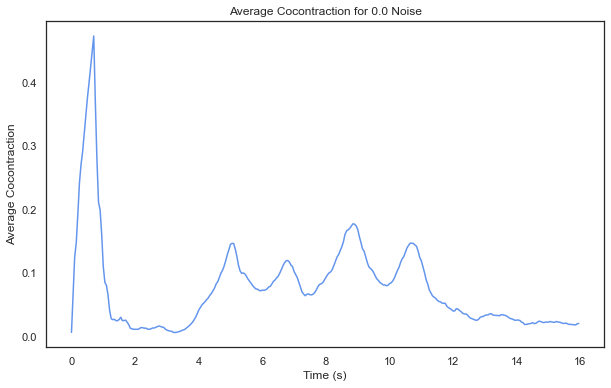

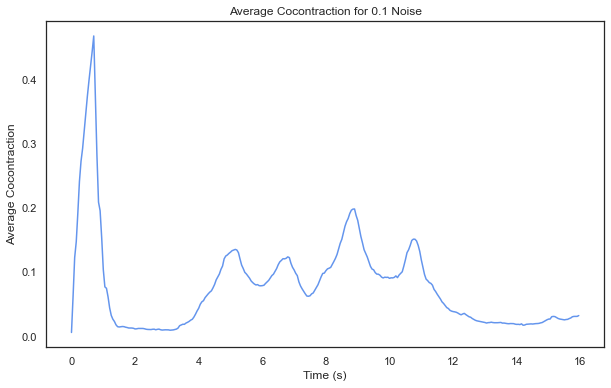

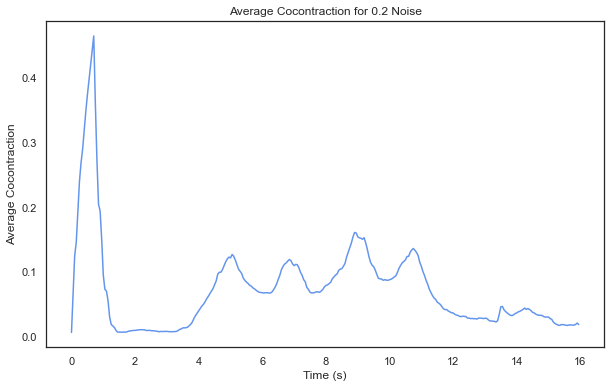

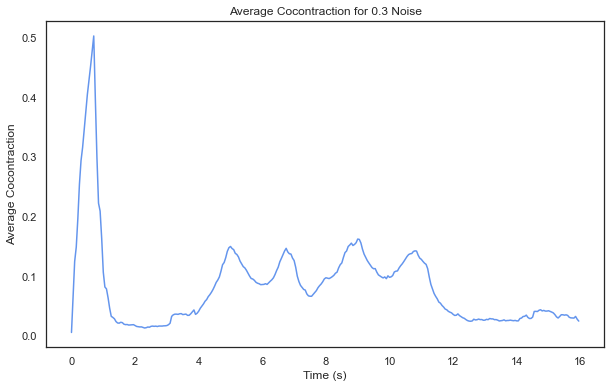

In [76]:
# Create a pivot table for avg. cocontraction at each noise level across all participants
pivot_participants = pd.pivot_table(results, values="Cocontraction", index=["Noise", "Time"], aggfunc="mean").reset_index()

noise_levels = pivot_participants['Noise'].unique()

for n in noise_levels:
    noise_data = pivot_participants[pivot_participants['Noise'] == n]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=noise_data, x="Time", y="Cocontraction", color='cornflowerblue')

    plt.xlabel('Time (s)')
    plt.ylabel('Cocontraction')
    plt.title(f'Average Cocontraction for {n} Noise')
    plt.show()

In [93]:
model = ols('Cocontraction ~ C(Noise)', data=results).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq        df          F        PR(>F)
C(Noise)      3.448522       3.0  29.018964  9.456370e-19
Residual  10140.586075  255996.0        NaN           NaN

In [94]:
test = pairwise_tukeyhsd(endog=results['Cocontraction'], groups=results['Noise'], alpha=0.05)

tukey_data = pd.DataFrame(data=test._results_table.data[1:], columns=test._results_table.data[0])
tukey_data

group1  group2  meandiff   p-adj   lower   upper  reject
0     0.0     0.1    0.0018  0.3526 -0.0010  0.0047   False
1     0.0     0.2   -0.0026  0.0839 -0.0055  0.0002   False
2     0.0     0.3    0.0074  0.0000  0.0045  0.0102    True
3     0.1     0.2   -0.0045  0.0004 -0.0073 -0.0016    True
4     0.1     0.3    0.0055  0.0000  0.0027  0.0084    True
5     0.2     0.3    0.0100  0.0000  0.0071  0.0129    True